In [22]:
import pandas
import csv 
import numpy as np
from datasketch import MinHash, MinHashLSH
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [23]:
# Shingle generators 
# Arguments : Message string, shingle size {in words}
# Returns : All shingles formed with k words
def shingle_generator(message, k):
    message = message.split(' ')
    item_set = []
    for i in range(0, len(message)-k):
        shingle = ""
        for j in range(0, k):
            shingle = shingle + message[i+j] + " "
        item_set.append(shingle)
    return item_set

In [24]:
# dump the CSV file into a numpy array. 
csv_reader = pandas.read_pickle('data/string_study.pkl')
# final_arr = csv_reader.values
# final_arr = np.array(final_arr)

In [25]:
csv_reader.head(2)

,atime,task,deployment,raw,dtime,msg,_info
0,1524387149611,attach-volume,wig_project_003,2018-04-22 10:52:29.611 17979 ERROR rallyteste...,2018-04-22 08:00:00,waiting for Server to become ('ACTIVE'),Rally tired waiting 1440.00 seconds for Server...
1,1524387185889,boot-from-volume-linux,gva_shared_016,2018-04-22 10:53:05.889 25667 ERROR rallyteste...,2018-04-22 08:00:00,"Quota exceeded for cores, instances: Requested...","Quota exceeded for cores, instances: Requested..."


In [26]:
csv_reader._info.apply(lambda x:len(x.split(' '))).head(3)

0    14
1    22
2    22
Name: _info, dtype: int64

In [27]:
csv_reader._info.apply(lambda x:x).head(3)

0    Rally tired waiting 1440.00 seconds for Server...
1    Quota exceeded for cores, instances: Requested...
2    Quota exceeded for cores, instances: Requested...
Name: _info, dtype: object

In [28]:
csv_reader._info.apply(lambda x:len(x.split(' '))).head(3)

0    14
1    22
2    22
Name: _info, dtype: int64

In [29]:
csv_reader["mylen"] = csv_reader._info.apply(lambda x:len(x.split(' ')))

In [30]:
csv_reader.head(3)

,atime,task,deployment,raw,dtime,msg,_info,mylen
0,1524387149611,attach-volume,wig_project_003,2018-04-22 10:52:29.611 17979 ERROR rallyteste...,2018-04-22 08:00:00,waiting for Server to become ('ACTIVE'),Rally tired waiting 1440.00 seconds for Server...,14
1,1524387185889,boot-from-volume-linux,gva_shared_016,2018-04-22 10:53:05.889 25667 ERROR rallyteste...,2018-04-22 08:00:00,"Quota exceeded for cores, instances: Requested...","Quota exceeded for cores, instances: Requested...",22
2,1524387196073,boot-linux,gva_shared_016,2018-04-22 10:53:16.073 25840 ERROR rallyteste...,2018-04-22 08:00:00,"Quota exceeded for cores, instances: Requested...","Quota exceeded for cores, instances: Requested...",22


In [32]:
# csv_reader.query().head(3)

In [40]:
pandas.options.display.max_colwidth=200


In [46]:
csv_reader.size

275552

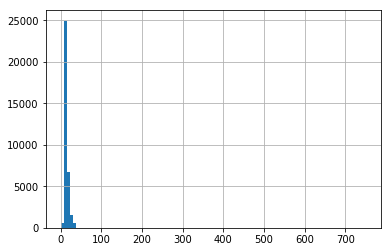

In [67]:
csv_reader.mylen.hist(bins = 99)

In [42]:
csv_reader.query("mylen > 599")._info

32865    Rally tired waiting 1200.00 seconds for Pod nginx-cvmfs-ncoda:1f9bb71a-3cd1-11e8-b7c8-fa163eddb852 to become Ready current status {'conditions': [{'last_probe_time': None,                  'last_t...
32867    Rally tired waiting 1200.00 seconds for Pod nginx-cvmfs-drhmx:8c4476a5-3cd5-11e8-b7cd-fa163ef444cc to become Ready current status {'conditions': [{'last_probe_time': None,                  'last_t...
Name: _info, dtype: object

In [6]:
# define the test sets of threshold and the number of permutations
threshold_set = [.001, .01, .1, .2, .4, .5]
permutations_set = [128, 151]

In [7]:
# extract all the raw_messsages from the error logs
raw_msgs = final_arr[0:, -1]
raw_msgs.shape
raw_msgs[1:2]

array(["Rally tired waiting 1440.00 seconds for Server rally-9db3-aPln:176b6fd3-8a2d-4b60-a5bd-73575c4ad161 to become ('ACTIVE') current status BUILD"],
      dtype=object)

In [9]:
# Generate the set of words of all raw messages
message_set = []
for item in raw_msgs:
#     set_of_words = set(item.split(' '))
    # Shingle size is set to 3 words
    set_of_words = set(shingle_generator(item, 2))
    message_set.append(set_of_words)

In [10]:
# Run the Min hash algo for all the permutations
for permutations in permutations_set:
    # Generalize the name of the output text file. 
    filename = "output_"
    # Update the permutaitons in the 'filename'
    filename = filename + str(permutations)
    m = []
    for i in range (0, len(message_set)):
        m_temp = MinHash(num_perm=permutations)
        m.append(m_temp)
    i = 0
    for message in message_set:
        for word in message:
            m[i].update(word.encode('utf-8'))
        i = i + 1
    
    # Run the algo for all thresholds in the threshold set
    for threshold in threshold_set:
        temp_filename = filename
        filename = filename + "_" + str(threshold)
        lsh = MinHashLSH(threshold=threshold, num_perm=permutations)
        for i in range (1, len(m)):
            string = "m" + str(i)
            lsh.insert(string, m[i])
        # Find all the messages similar to the fist message with a specified threshold
        result = lsh.query(m[1])
        
        # Write the result to a file
        print "Writing to " + filename
        filename = filename + ".txt"
        with open(filename, 'w') as f:
            for item in result:
                f.write("%s\n" % item)
        
        # Reset the file name
        filename = temp_filename

Writing to output_128_0.001
Writing to output_128_0.01
Writing to output_128_0.1
Writing to output_128_0.2
Writing to output_128_0.4
Writing to output_128_0.5
Writing to output_151_0.001
Writing to output_151_0.01
Writing to output_151_0.1
Writing to output_151_0.2
Writing to output_151_0.4
Writing to output_151_0.5


In [11]:
print "Successfully completed. No of files created " + str(len(permutations_set)*len(threshold_set))

Successfully completed. No of files created 12
